# Single-phase flow in fractured porous media

Consider the following mixed-dimensional model for single-phase flow in fractured porous media.
\begin{align}
\renewcommand{\jump}[1]{[\mskip-5mu[ #1 ]\mskip-5mu]}
\renewcommand{\avg}[1]{\{\mskip-5mu\{ #1 \}\mskip-5mu\}}
\end{align}
\begin{align}
-\nabla\cdot\left(\mathbf{K}_i\nabla p_i\right) &= q_i &\qquad &\text{in } \Omega_i, \quad &i&=1,2 ,\\
-\nabla_\parallel \cdot \left( d\mathbf{K}^\Gamma_\parallel \nabla_\parallel \left( d p^\Gamma\right) \right) &= q^\Gamma - \jump{\mathbf{K}\nabla p} &\qquad &\text{in }\Gamma ,\\
-\avg{\mathbf{K} \nabla p} \cdot {n} &= K^\Gamma_\perp \left( p_1 - p_2 \right)  &\qquad &\text{on }\Gamma ,\\
-\jump{\mathbf{K} \nabla p} &= 12 K_\perp^\Gamma \left( \avg{p} - p^\Gamma  \right) &\qquad &\text{on } \Gamma ,\\
p_i &= g_i &\qquad &\text{on } \rho_i , &i&=1,2 , \\
p^\Gamma &= g^\Gamma &\qquad &\text{on } \partial\Gamma. \\
\end{align}

## Test problem
We consider the [vertical](grids/vertical.rst) grid file defining the domains $\Omega_1 = [0,0.5] \times [0,1]$, $\Omega_2 = [0.5,1] \times [0,1]$ and $\Gamma = \{ 0.5 \} \times [0,1]$ and the physical parameters $\mathbf{K} = \mathbf{I}$, $\mathbf{K}_\parallel^\Gamma = \mathbf{I}$, $K_\perp^\Gamma = 2$ and $d = 1$.

In [1]:
from dune.grid import reader
from dune.mmesh import mmesh, domainMarker
from ufl import *

dim = 2
file = "grids/vertical.msh"

gridView = mmesh((reader.gmsh, file), dim)
igridView = gridView.hierarchicalGrid.interfaceGrid

K   = Identity(dim)
K_g = Identity(dim)
K_perp = 2
d = 1

We use a manufactured solution given by
\begin{align*}
p_1 \left( {x} \right) &=  \sin\left( 4x_1 \right) \cos\left( \pi x_2 \right) ,\\
p_2 \left( {x} \right) &=  \cos\left( 4x_1 \right) \cos\left( \pi x_2 \right) ,\\
p^\Gamma \left( {s}\right) &= \tfrac{3}{4} \left( \cos\left( 2\right) + \sin\left( 2\right) \right) \cos\left( \pi x_2 \right)
\end{align*}
and the source terms
\begin{align*}
q_1 \left( {x} \right) &= \left( 16 + \pi^2 \right) \sin\left( 4x_1 \right) \cos\left( \pi x_2 \right) ,\\
q_2 \left( {x} \right) &=  \left( 16 + \pi^2 \right) \cos\left( 4x_1 \right) \cos\left( \pi x_2 \right),\\
q^\Gamma \left( {s} \right) &= \left( \cos\left( 2\right) + \sin\left( 2 \right) \right) \left( 4 + \tfrac{3}{4} d^2 \pi^2 \right) \cos\left( \pi s_2 \right).
\end{align*}

In [2]:
dm = domainMarker(gridView)
x   = SpatialCoordinate( Cell("triangle", dim) )
x_g = SpatialCoordinate( Cell("interval", dim) )

p1 = sin(4*x[0])*cos(pi*x[1])
p2 = cos(4*x[0])*cos(pi*x[1])
pexact   = dm*p1 + (1-dm)*p2
p_gexact = 3./4.*(cos(2.)+sin(2.))*cos(pi*x_g[1])
q   = (16.+pi**2) * pexact
q_g = 4./3.*p_gexact*(4. + 3./4.* d**2 * pi**2)
g   = pexact
g_g = p_gexact

## Mixed-dimensional interior-penalty DG formulation
An IPDG formulation for the problem above can be written as:

Find $( p_h , p_h^\Gamma ) \in \mathcal{S}_h^{PM} \times \mathcal{S}_h^\Gamma$, s.t.
\begin{align}
\mathcal{B}_{DG} \big( ( p_h  , p_h^\Gamma ) , ( \phi_h , \phi_h^\Gamma )\big) = \mathcal{L}_{DG} ( \phi_h , \phi_h^\Gamma )
\end{align}
for all $( \phi_h , \phi_h^\Gamma ) \in  \mathcal{S}_h^{PM} \times \mathcal{S}_h^\Gamma$, where
\begin{align}
\begin{split}
\mathcal{B}_{DG} \big( ( p_h  , p_h^\Gamma ) , ( \phi_h , \phi_h^\Gamma )\big) &:= \mathcal{B}_{DG}^{PM} ( p_h , \phi_h ) + \mathcal{B}^\Gamma_{DG} ( p_h^\Gamma , \phi_h^\Gamma ) + \mathcal{K}_{DG}  \big( ( p_h, p_h^\Gamma ) , ( \phi_h , \phi_h^\Gamma )\big), \\
\mathcal{L}_{DG} ( \phi_h , \phi_h^\Gamma ) &:= \mathcal{L}^{PM}_{DG} ( \phi_h ) + \mathcal{L}^\Gamma_{DG} ( \phi_h^\Gamma ),
\end{split}
\end{align}
where the forms are defined below.

In [3]:
from dune.fem.space import dglagrange
order = 2
space   = dglagrange( gridView, order=order)
space_g = dglagrange(igridView, order=order)

p   = TrialFunction(space)
phi = TestFunction(space)
p_g   = TrialFunction(space_g)
phi_g = TestFunction(space_g)
n   = FacetNormal(space)
n_g = FacetNormal(space_g)

from dune.mmesh import interfaceIndicator
I = interfaceIndicator(igridView)

## Bulk forms
\begin{align}
\mathcal{B}^{PM}_{DG} \left( p_h , \phi_h \right) &:= \int_\Omega \mathbf{K} \nabla_h p_h \cdot \nabla_h \phi_h \,{d} V \\
&\quad + \int_{\mathcal{F}^{\circ}\setminus\Gamma} \left( \mu \jump{p_h}\cdot\jump{\phi_h} - \avg{\mathbf{K} \nabla_h p_h} \cdot \jump{\phi_h} - \jump{p_h} \cdot \avg{\mathbf{K} \nabla_h \phi_h }\right) \,{d}\sigma \\
&\quad + \int_{\partial\Omega} \mu  p_h \phi_h \,{d}\sigma -  \int_{\partial\Omega} \left( p_h  \mathbf{K} \nabla_h \phi_h + \phi_h \mathbf{K} \nabla_h p_h \right) \cdot {d}{\sigma}, \\
\mathcal{L}^{PM}_{DG} \left( \phi_h\right) &:= \int_\Omega q \phi_h \,{d} V +\int_{\partial\Omega} \mu  g \phi_h \,{d}\sigma - \int_{\partial\Omega} g \mathbf{K} \nabla_h \phi_h \cdot {d}{\sigma}, \\
\end{align}

In [4]:
mu = 1e3

B = dot(dot(grad(p), K), grad(phi)) * dx
B += mu * jump(p) * jump(phi) * (1-I)*dS
B -= jump(phi) * dot(avg(dot(grad( p ), K)), n('+')) * (1-I)*dS
B -= jump( p ) * dot(avg(dot(grad(phi), K)), n('+')) * (1-I)*dS
B += mu * p * phi * ds
B -= p * dot(dot(grad(phi), K), n) * ds
B -= phi * dot(dot(grad(p), K), n) * ds

L = q * phi * dx
L += mu * g * phi * ds
L -= g * dot(dot(grad(phi), K), n) * ds

## Interface forms
\begin{align}
\mathcal{B}^\Gamma_{DG} \left( p_h^\Gamma , \phi_h^\Gamma \right) &:= \int_\Gamma \mathbf{K}_\parallel^\Gamma \nabla_{\parallel h}\left( d p_h^\Gamma \right)  \cdot \nabla_{\parallel h} \left( d \phi_h^\Gamma \right) \,{d}\sigma
+ \int_{\mathcal{E}_\Gamma^\circ} d \Big[ \mu^\Gamma  d \jump{ p_h^\Gamma} \cdot \jump{\phi_h^\Gamma} \\
&\quad - \avg{\mathbf{K}_\parallel^\Gamma \nabla_{\parallel h} \left( d p_h^\Gamma \right) } \cdot \jump{\phi_h^\Gamma} - \jump{p_h^\Gamma} \cdot \avg{\mathbf{K}_\parallel^\Gamma \nabla_{\parallel h}\left( d \phi_h^\Gamma\right) } \Big] \,{d}r \\
&\quad + \int_{\partial\Gamma} \mu^\Gamma d^2 p_h^\Gamma \phi_h^\Gamma \,{d} r - \int_{\partial \Gamma} d \left[ p_h^\Gamma \mathbf{K}_\parallel^\Gamma \nabla_{\parallel h} \left( d \phi_h^\Gamma \right) + \phi_h^\Gamma \mathbf{K}_\parallel^\Gamma \nabla_{\parallel h} \left( d p_h^\Gamma\right)\right] \cdot {d}{r},\\
\mathcal{L}_{DG}^\Gamma \left( \phi_h^\Gamma \right) &:= \int_\Gamma q^\Gamma \phi_h^\Gamma \,{d}\sigma + \int_{\partial\Gamma} \mu^\Gamma d^2 g^\Gamma \phi_h^\Gamma \,{d} r - \int_{\partial\Gamma} d g^\Gamma \mathbf{K}_\parallel^\Gamma \nabla_{\parallel h} \left( d \phi_h^\Gamma \right) \cdot {d} {r}, \\
\end{align}

In [5]:
B_g = d * dot(dot(grad(d*p_g), K_g), grad(d*phi_g)) * dx
B_g += d * mu * d * jump(p_g) * jump(phi_g) * dS
B_g -= d * jump(phi_g) * dot(avg(dot(grad(d *  p_g ), K_g)), n_g('+')) * dS
B_g -= d * jump( p_g ) * dot(avg(dot(grad(d * phi_g), K_g)), n_g('+')) * dS
B_g += mu * d**2 * p_g * phi_g * ds
B_g -= d**2 * p_g * dot(dot(grad(d * phi_g), K_g), n_g) * ds
B_g -= d**2 * phi_g * dot(dot(grad(d * p_g), K_g), n_g) * ds

L_g = d * q_g * phi_g * dx
L_g += mu * d**2 * g_g * phi_g * ds
L_g -= d**2 * g_g * dot(dot(grad(d * phi_g), K_g), n_g) * ds

## Coupling form
\begin{align}
\mathcal{K}_{DG} \left( \left( p_h , p_h^\Gamma \right) , \left( \phi_h , \phi_h^\Gamma \right) \right) & := \int_\Gamma K_\perp^\Gamma \jump{p_h} \cdot \jump{\phi_h} \,{d} \sigma +  \int_\Gamma \beta^\Gamma \left( \avg{p_h} - p_h^\Gamma \right) \left( \avg{\phi_h} - \phi_h^\Gamma \right) \,{d}\sigma .
\end{align}

In [6]:
from dune.mmesh import trace, skeleton
ph   = space.interpolate(0, name="pressure")
ph_g = space_g.interpolate(0, name="pressure_g")

xi = 2./3.
beta = 4. * K_perp / (2. * xi - 1)

K_DG = K_perp * jump(p) * jump(phi) * I*dS
K_DG += beta * ( avg(p) * avg(phi) - avg(skeleton(ph_g)) * avg(phi) ) * I*dS

K_DG_g = beta * ( -avg(trace(ph)) * phi_g + p_g * phi_g ) * dx

## Solve

We use the iterative solution strategy provided by Dune-MMesh.

In [7]:
from dune.fem.scheme import galerkin
from dune.mmesh import iterativeSolve

scheme   = galerkin([B   + K_DG   == L  ], solver=("suitesparse", "umfpack"))
scheme_g = galerkin([B_g + K_DG_g == L_g], solver=("suitesparse", "umfpack"))

res = iterativeSolve(schemes=(scheme, scheme_g), targets=(ph, ph_g), verbose=True)

  0: [ 2.36e+02  1.62e+00 ]
  1: [ 4.08e+00  6.62e-02 ]
  2: [ 2.34e-01  4.01e-03 ]
  3: [ 1.43e-02  2.46e-04 ]
  4: [ 8.77e-04  1.51e-05 ]
  5: [ 5.38e-05  9.27e-07 ]
  6: [ 3.30e-06  5.69e-08 ]
  7: [ 2.03e-07  3.49e-09 ]
  8: [ 1.25e-08  2.14e-10 ]
  9: [ 7.64e-10  1.32e-11 ]


## Plot

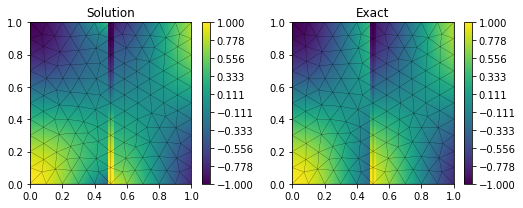

In [8]:
import matplotlib.pyplot as plt
from dune.fem.plotting import plotPointData

fig, axs = plt.subplots(1, 2, figsize=(8, 3))
axs[0].set_title("Solution")
plotPointData(ph,   figure=(fig, axs[0]))
plotPointData(ph_g, figure=(fig, axs[0]), linewidth=0.04, colorbar=None)

phexact   = space.interpolate(pexact, name="pexact")
ph_gexact = space_g.interpolate(p_gexact, name="p_gexact")
axs[1].set_title("Exact")
plotPointData(phexact,   figure=(fig, axs[1]))
plotPointData(ph_gexact, figure=(fig, axs[1]), linewidth=0.04, colorbar=None)